In [2]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [3]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [4]:
nLat = 1024
nTime = nLat
nTimeMultiplier = 10
nSims = 50

phi0 = 1.
temp = 1.

lenLat = 100.;
nCols = 2
nyq = nLat//2+1
spec = nyq
alpha = 8
dx = lenLat/nLat; print(dx)
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

0.09765625


### Theoretical Field PS 

In [5]:
eff_potential_sim_location = lambda nT, nL, tem, phi, lam, m2, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_empirical_potential_with_changed_potential_m2{:.4f}'.format(m2)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
eff_field_mass_sim_location = lambda nT, nL, tem, phi, lam, m2, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_empirical_potential_with_changed_field_mass_m2{:.4f}'.format(m2)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
null_sim_location = lambda nT, nL, tem, phi, lam, m2, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_empirical_potential_null_m2{:.4f}'.format(m2)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'

def extract_eff_potential(nT, nL, tem, lamb, m2, sim):
    data = np.genfromtxt(eff_potential_sim_location(nT*nTimeMultiplier, nL, temp, phi0, lamb, m2, sim))
    return np.asarray([np.reshape(data[:,col], (nT*nTimeMultiplier, nL))[-nT:] for col in range(nCols)])

def extract_eff_field_mass(nT, nL, tem, lamb, m2, sim):
    data = np.genfromtxt(eff_field_mass_sim_location(nT*nTimeMultiplier, nL, temp, phi0, lamb, m2, sim))
    return np.asarray([np.reshape(data[:,col], (nT*nTimeMultiplier, nL))[-nT:] for col in range(nCols)])

def extract_null(nT, nL, tem, lamb, m2, sim):
    data = np.genfromtxt(null_sim_location(nT*nTimeMultiplier, nL, temp, phi0, lamb, m2, sim))
    return np.asarray([np.reshape(data[:,col], (nT*nTimeMultiplier, nL))[-nT:] for col in range(nCols)])

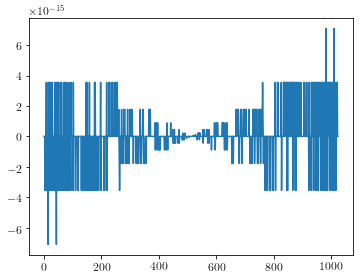

In [17]:
norm = 1./ phi0 / np.sqrt(2.*lenLat)
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2.*np.pi
freqs2 = np.arange(-nLat//2, nLat//2, 1)*2*np.pi/lenLat
plt.plot(freqs-freqs2)
omega = lambda m2: freqs**2. + m2

spectral_field = lambda tem: np.asarray([norm * np.sqrt(2./(np.exp(omega(m2)[k]**0.5/tem) - 1.)) / omega(m2)[k]**0.25 if k != nLat//2 else 0. for k in range(nLat)])
sigma0sq_th = lambda tem: np.sum( np.abs(spectral_field(tem))**2. )

### Extract data from files

In [6]:
m2bare = 1.
m2eff = 0.4
lambbare = 1.
lambeff = 0.423

m2 = m2eff
lamb = lambeff
all_eff_potential_data = np.asarray([extract_eff_potential(nTime, nLat, temp, lamb, m2, sim) for sim in range(nSims)])
print('Done')

m2 = m2bare
lamb = lambbare
all_eff_field_mass_data = np.asarray([extract_eff_field_mass(nTime, nLat, temp, lamb, m2, sim) for sim in range(nSims)])
print('Done')

m2 = m2bare
lamb = lambbare
all_null_data = np.asarray([extract_null(nTime, nLat, temp, lamb, m2, sim) for sim in range(nSims)])
print('Done')

all_data = [all_eff_potential_data, all_eff_field_mass_data, all_null_data]

Done
Done
Done


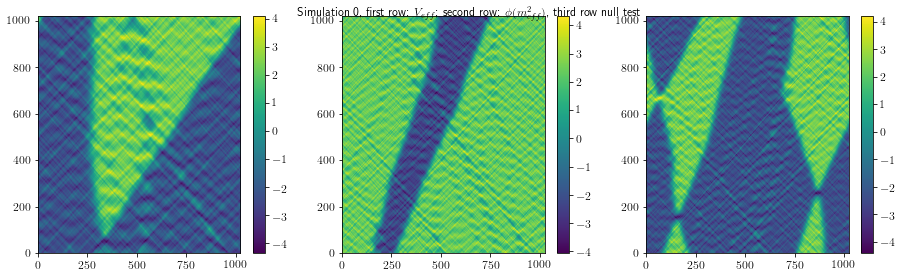

In [7]:
if True:
    sim = random.randint(0, nSims-1)
    fig, ax = plt.subplots(1, len(all_data), figsize = (4*len(all_data)+4, 4))
    for iii in range(len(all_data)):
        im0 = ax[iii].imshow(all_data[iii][sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[iii])
    plt.suptitle('Simulation '+str(sim)+r', first row: $V_{eff}$; second row: $\phi(m^2_{eff})$, third row null test')
    plt.show()

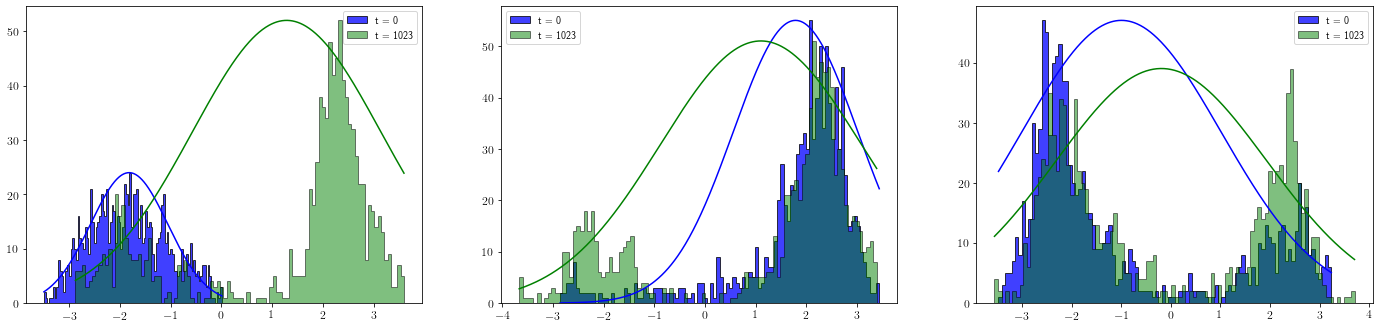

In [8]:
if True:
    fig, ax = plt.subplots(1, len(all_data), figsize = (25, 5))
    for jjj in range(len(all_data)):
        ii = 1
        colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
        for time in [0, nTime-1]:
            col = next(colors)
            ii = ii - 0.25
            PDF1d = []
            for sim in range(nSims):
                PDF1d += all_data[jjj][sim][0][time].tolist()

            PDF1d = np.asarray(PDF1d)
            sigma, mu = np.std(PDF1d), np.mean(PDF1d)
            n, bins, patches = ax[jjj].hist(PDF1d, bins=100, label='t = '+str(time), color=col, alpha=ii, ec='k', histtype='stepfilled')
            x = np.linspace(min(bins), max(bins), 500)
            gaussian = scp.stats.norm.pdf(x, mu, sigma)
            ax[jjj].plot(x, gaussian*(max(n)/max(gaussian)), color=col)

            k2, p = scp.stats.normaltest(PDF1d)
            alpha = 1e-3
            if p > alpha:  # null hypothesis: x comes from a normal distribution
                print("p = {:g}".format(p))
                print("Field may be Gaussian.")
        ax[jjj].legend()
    plt.show()

In [9]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_truncation_frequency(PowSpec, oo, kk):
    kselect = np.sort(kk[kk>0])[0]
    window_in_k = np.mean(PowSpec[:, kk==kselect], axis=1)[(np.in1d(oo,kk))&(oo>0)]
    smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=0.5, mode='constant')
    minpeaks, properties = scs.find_peaks(-smooth_window_in_k, height=-max(smooth_window_in_k))
    minpeaks, height = minpeaks[0], -properties['peak_heights'][0]

    maxpeaks, properties = scs.find_peaks(smooth_window_in_k, height=min(smooth_window_in_k))
    return ([minpeaks, height] if minpeaks < maxpeaks[properties['peak_heights']==max(properties['peak_heights'])] else [0, 0])

def get_masses(bool, multiplier):
    masses_null, masses_eff_potential, masses_eff_field = [], [], []
    if bool:
        fig, ax = plt.subplots(1, 2*len(all_data), figsize = (25, 4))
    
    for masses, iii in zip([masses_eff_potential, masses_eff_field, masses_null], range(len(all_data))):
        PowSpec = np.mean(np.abs(np.fft.fftshift(np.fft.fft2(all_data[iii][:,0])))**2., axis=0)
        kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
        KK, OO = np.meshgrid(kk,oo)
        
        trunc_freq, trunc_amp = get_truncation_frequency(PowSpec, oo, kk)

        PowSpec = PowSpec*(np.abs(OO) >= oo[oo>0][trunc_freq])
        maxVal = np.mean(PowSpec) + multiplier * np.std(PowSpec)
        osccoords = np.argwhere(PowSpec > max(trunc_amp, maxVal))

        popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
        if popt[-1] < 0: masses.append('nan')
        else: masses.append(popt[-1])

        if bool:
                lim = 3
                ax[iii*2+0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
                ax[iii*2+0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
                ax[iii*2+0].set_title((r'$V_{eff}$ ' if iii == 0 else r'$\phi(m^2_{eff})$ ' if iii == 1 else r'null'))
                ax[iii*2+0].set_ylim(0,lim)
                ax[iii*2+0].set_xlim(-lim,lim)
                ax[iii*2+0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
                ax[iii*2+0].legend()

                lim = 3
                ax[iii*2+1].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'y', label=f'$m^2=$%5.5f'%popt[-1])
                im = ax[iii*2+1].imshow(PowSpec, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                #ax[iii*2+1].imshow(np.amax(PowSpec)/2.*(coords(p3) & cdsnot(p3+0.2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                clb = plt.colorbar(im, ax = ax[iii*2+1])
                ax[iii*2+1].set_title((r'$V_{eff}$ ' if iii == 0 else r'$\phi(m^2_{eff})$ ' if iii == 1 else r'null'))
                ax[iii*2+1].set_xlabel(r'$\bar{k}$')
                ax[iii*2+1].set_ylabel(r'$\bar{\omega_k}$')
                ax[iii*2+1].set_ylim(0,lim)
                ax[iii*2+1].set_xlim(-lim,lim)
                ax[iii*2+1].axvline(0, color='white', ls=':')
                ax[iii*2+1].axhline(0, color='white', ls=':')
                ax[iii*2+1].legend()
    if bool: plt.show()
    return np.asarray(masses_eff_potential), np.asarray(masses_eff_field), np.asarray(masses_null)

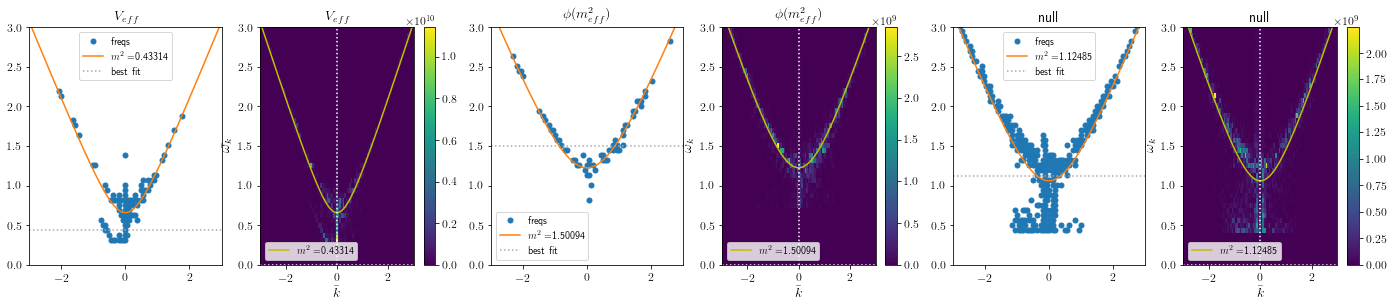

$V(\lambda =  0.42, m^2 =  0.40), \phi(\lambda =  1.00, m^2 =  1.00) $Predictions:  0.6759472316848633 0.9095810806477208  vs. Data:  0.4331410477033494
$V(\lambda =  1.00, m^2 =  1.00), \phi(\lambda =  1.00, m^2 =  0.40) $Predictions:  1.5670614347315603 0.3095810806477209  vs. Data:  1.5009439675585579
$V(\lambda =  1.00, m^2 =  1.00), \phi(\lambda =  1.00, m^2 =  1.00) $Predictions:  1.272385763534201 0.9095810806477208  vs. Data:  1.12485122447194


In [10]:
multiplier = 10
mass_from_data = get_masses(True, multiplier)


V = lambda x, m2, lamb: 0.5 * m2 * x**2. + lamb * x**4. / 24.
m2_from_rms = lambda iii, m2, lamb: np.abs(-m2 + 0.5*lamb*np.mean(all_data[iii][:,0,-1]**2.)) # these are potential values
m2_from_PS = lambda m2, lamb: np.abs(-m2 + 0.5*lamb*sigma0sq_th(temp)) # there are field values
for iii in range(len(all_data)):
    if iii == 0:
        print(r'$V(\lambda = %5.2f, m^2 = %5.2f), \phi(\lambda = %5.2f, m^2 = %5.2f)'%(lambeff, m2eff, lambbare, m2bare), '$Predictions: ', m2_from_rms(iii, m2eff, lambeff), m2_from_PS(m2bare, lambbare), ' vs. Data: ', np.mean(mass_from_data[iii]))

    if iii == 1:
        print(r'$V(\lambda = %5.2f, m^2 = %5.2f), \phi(\lambda = %5.2f, m^2 = %5.2f)'%(lambbare, m2bare, lambbare, m2eff), '$Predictions: ', m2_from_rms(iii, m2bare, lambbare), m2_from_PS(m2eff, lambbare), ' vs. Data: ', np.mean(mass_from_data[iii]))

    if iii == 2:
        print(r'$V(\lambda = %5.2f, m^2 = %5.2f), \phi(\lambda = %5.2f, m^2 = %5.2f)'%(lambbare, m2bare, lambbare, m2bare), '$Predictions: ', m2_from_rms(iii, m2bare, lambbare), m2_from_PS(m2bare, lambbare), ' vs. Data: ', np.mean(mass_from_data[iii]))

(129, 1024)


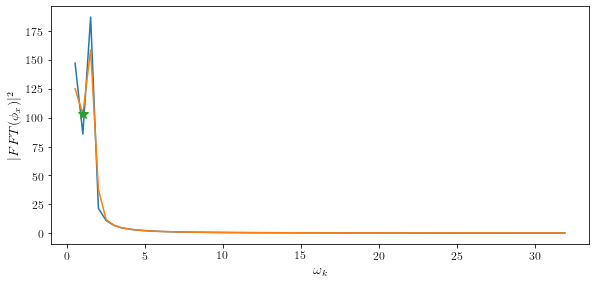

1.912483437975792


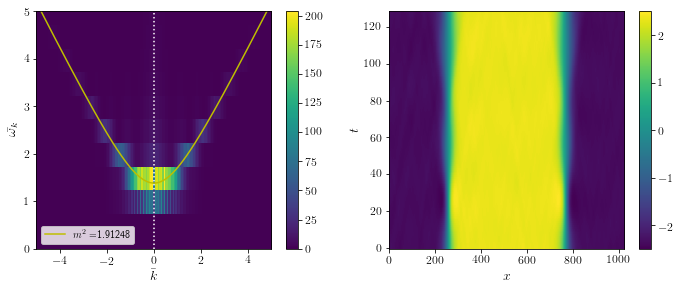

In [11]:
average_sim = np.load('/home/dpirvu/project/thermal_bubbles/experiments/wall_solution_with_fluct_at_Temp1./average_simulation_of_stable_soln_at_T1.npy')
average_powspec = np.load('/home/dpirvu/project/thermal_bubbles/experiments/wall_solution_with_fluct_at_Temp1./average_pow_spec_of_stable_soln_at_T1.npy')
PowSpec = average_powspec; print(np.shape(PowSpec))
T, N = np.shape(PowSpec)
kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
KK, OO = np.meshgrid(kk,oo)


pick_freqs = 1
kselect = np.sort(kk[kk>0])[:pick_freqs]
window_in_k = np.mean(PowSpec[:, kk==kselect], axis=1)[(oo>0)]
smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=0.5, mode='constant')
minpeaks, properties = scs.find_peaks(-smooth_window_in_k, height=-max(smooth_window_in_k))
trunc_freq, trunc_amp = oo[oo>0][minpeaks[0]], -properties['peak_heights'][0]

kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi

fig, ax = plt.subplots(1, 1, figsize = (10, 4))
plt.plot(oo[oo>0], window_in_k)
plt.plot(oo[oo>0], smooth_window_in_k)
plt.plot(trunc_freq, trunc_amp, marker='*', ms=10)
#plt.yscale('log')
plt.xlabel(f'$\omega_k$')
plt.ylabel(f'$|FFT(\phi_x)|^2$')
plt.show()


PowSpec = PowSpec*(np.abs(OO) >= trunc_freq)
maxVal = np.mean(PowSpec) + multiplier * np.std(PowSpec)
osccoords = np.argwhere(PowSpec > max(trunc_amp, maxVal))

mass_osc = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)[0][-1]; print(mass_osc)

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
lim = 5
ax[0].plot(kk, np.sqrt(omega_fit(kk, mass_osc)), color = 'y', label=f'$m^2=$%5.5f'%mass_osc)
im = ax[0].imshow(PowSpec, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
clb = plt.colorbar(im, ax = ax[0])
ax[0].set_xlabel(r'$\bar{k}$')
ax[0].set_ylabel(r'$\bar{\omega_k}$')
ax[0].axvline(0, color='white', ls=':')

im = ax[1].imshow(average_sim, aspect='auto', interpolation='none', origin='lower')
clb = plt.colorbar(im, ax = ax[1])
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$t$')

ax[0].set_ylim(0,lim)
ax[0].set_xlim(-lim,lim)
ax[0].legend()
plt.show()

### Get profile of omega ^2

1024


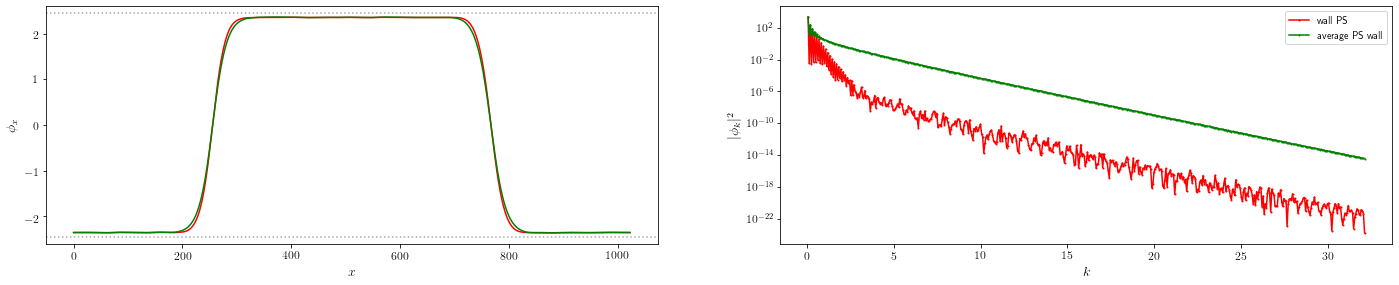

In [12]:
wall_profile = np.load('/home/dpirvu/project/thermal_bubbles/experiments/wall_solution_with_fluct_at_Temp1./stable_solution_at_T1.npy')

wall_PS = np.abs(np.fft.fftshift(np.fft.fft(wall_profile, norm='ortho')))**2.
freqs_wall = np.fft.fftshift(np.fft.fftfreq(len(wall_PS), d=dx))*2*np.pi; print(len(freqs_wall))
actual_wall_PS = np.mean(average_powspec, axis=0)

fig, ax = plt.subplots(1, 2, figsize = (25, 4))
ax[0].plot(np.arange(len(wall_profile)), wall_profile, 'r')
ax[0].plot(np.arange(len(wall_profile)), np.mean(average_sim, axis=0), 'g', ms=1)

ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$\phi_x$')
ax[0].axhline(-m2bare*np.sqrt(6/lambbare), linestyle=":", color='darkgray')
ax[0].axhline(m2bare*np.sqrt(6/lambbare), linestyle=":", color='darkgray')
ax[1].plot(freqs_wall[freqs_wall>0], wall_PS[freqs_wall>0], 'ro', ms=1, linestyle='-', label='wall PS')
ax[1].plot(freqs_wall[freqs_wall>0], actual_wall_PS[freqs_wall>0], 'go', ms=1, linestyle='-', label='average PS wall')
ax[1].set_xlabel(f'$k$')
ax[1].set_ylabel(f'$|\phi_k|^2$')
ax[1].set_yscale('log')
ax[1].legend()

(1024, 1024)
frequencies averaged over:  [0.06283185]
picked omega =  0.06283185307179587
(1024, 1024)
frequencies averaged over:  [0.06283185]
picked omega =  0.06283185307179587
(1024, 1024)
frequencies averaged over:  [0.06283185]
picked omega =  0.06283185307179587


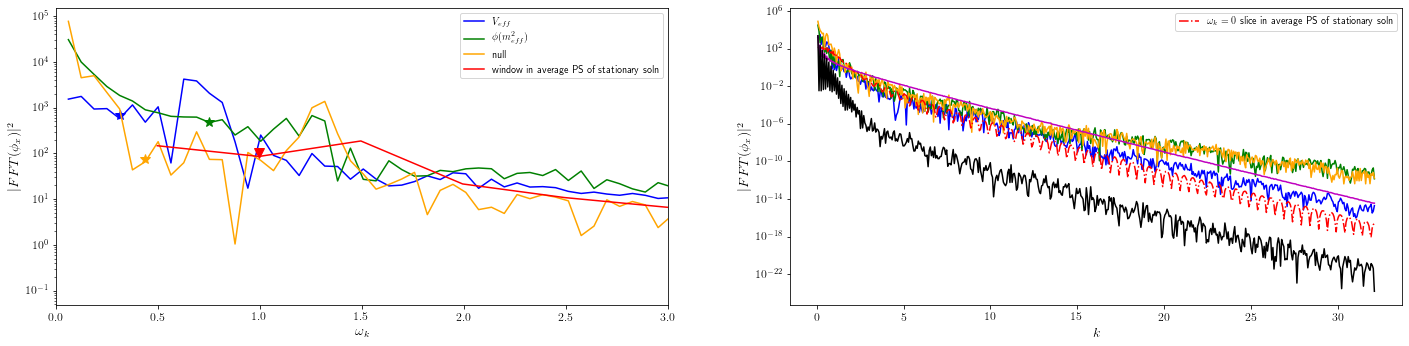

In [13]:
def get_pspec(iii, thresh):
    PowSpec = np.mean(np.abs(np.fft.fftshift(np.fft.fft2(all_data[iii][:,0], norm='ortho')))**2., axis=0)
    print(np.shape(PowSpec))
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
    trunc_freq, trunc_amp = get_truncation_frequency(PowSpec, oo, kk)

    pick_freq_window = (kk>0)&(kk<thresh); print('frequencies averaged over: ', kk[pick_freq_window])
    pick_omega = np.sort(oo[oo>0])[0]; print('picked omega = ', pick_omega)
    return oo[oo>0][trunc_freq], trunc_amp, np.mean(PowSpec[:, pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)], PowSpec[oo==pick_omega, kk>0], oo[oo>0], kk[kk>0]

def get_pspec_specific(thresh):
    T, N = np.shape(average_powspec)
    kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
    
    pick_freq_window = (kk>0)&(kk<thresh)
    pick_omega = np.sort(oo[oo>0])[0]

    window_in_k = np.mean(average_powspec[:, pick_freq_window], axis=1)[(oo>0)]
    smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=0.5, mode='constant')
    minpeaks, properties = scs.find_peaks(-smooth_window_in_k, height=-max(smooth_window_in_k))
    trunc_freq, trunc_amp = oo[oo>0][minpeaks[0]], -properties['peak_heights'][0]

    return trunc_freq, trunc_amp, window_in_k, average_powspec[oo==pick_omega, kk>0], oo[oo>0], kk[kk>0]


kkmax_to_average = 0.1

colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
fig, ax = plt.subplots(1, 2, figsize = (25, 5))
for iii in range(len(all_data)):
    col = next(colors)
    trunc_freq, trunc_amp, window_in_k, fix_omega, oo, kk = get_pspec(iii, kkmax_to_average)   
    ax[0].plot(oo, window_in_k, label=(r'$V_{eff}$ ' if iii == 0 else r'$\phi(m^2_{eff})$ ' if iii == 1 else r'null'), color=col)
    ax[0].plot(trunc_freq, trunc_amp, marker='*', ms=10, color=col)
    ax[1].plot(kk, fix_omega, color=col, linestyle='-')

col = next(colors)
test_trunc_freq, test_trunc_amp, test_window_in_k, test_fix_omega, test_oo, test_kk = get_pspec_specific(kkmax_to_average)   
ax[0].plot(test_oo, test_window_in_k, color=col, label='window in average PS of stationary soln')
ax[0].plot(test_trunc_freq, test_trunc_amp, marker='v', ms=10, color=col)
ax[1].plot(test_kk, test_fix_omega, color=col, linestyle='-.', label=r'$\omega_k = 0$ slice in average PS of stationary soln')

ax[1].plot(kk, actual_wall_PS[freqs_wall>0], color=next(colors), linestyle='-')
ax[1].plot(kk, wall_PS[freqs_wall>0], color=next(colors), linestyle='-')

ax[0].set_xlim(0,3)
ax[1].set_yscale('log')
ax[0].set_yscale('log')
[ax[i].set_xlabel((f'$\omega_k$' if i == 0 else f'$k$')) for i in range(len(ax))]
[i.set_ylabel(f'$|FFT(\phi_x)|^2$') for i in ax]
[i.legend() for i in ax]
plt.show()